## Introduction to the SAMPLED BASED DIAGONALIZATION

In [ ]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)

In [7]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'


In [8]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [-7.26415456e-18]
dimension= 640


#### Select the samples

In [9]:
prob=np.conjugate(psi0[:,0])*psi0[:,0]

In [10]:

n_instances=400
selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances,replace=False,p=prob)
print(selection)
effective_hamiltonian=lil_matrix((n_instances,n_instances))

for a,idx_a in enumerate(selection):
    for b,idx_b in enumerate(selection):
        effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]


effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')

print(effective_egs)


[100 536 136 601 376 508 427  26  13 609 469 287 570 477 572 108 209 429
 489 471  80 191 243  29 468  96  99  28 113  84  85 245 185 409  27 548
 595 606 340  11 138 115 563 302 374 226 233 623  35 102 430 221 557 305
 112 219 298   7 380 145 555  15 183   6  22 524 114 592 407 481 371 351
 301 123  38  87 466 144 262  30 634 467  93 513 231  86 289 428   8 316
 195  88  65 487  58 149 593 615  49 538 141 200 202  46 370  51  34  20
 389 433  47  89 187 127 526 501 235 365  82 432 442  21 214 552  83 290
  18 491 133 383 303 436 480 120 485 564 251 425 196   0 421 299 604 631
 189 582  24  14 505 142 182 459  79  56 532 324 355  53 465 216  32  17
  44  45 159 294 361 496 208 607 248 546 286 213 259 104 510 210 321 381
 638 315 506 494 207 318 596  52 530 186 542 385 118 116 519  57 238 204
 176 157 168 188 330 419 401 111 360  12 254 560  94  59   9 150   1 206
 382 338  39 198 379 462 310  91 313 291 554 121 412 544 386 147 227 483
  75  63 134 297 354 581  92 499 392  16 525 516 32

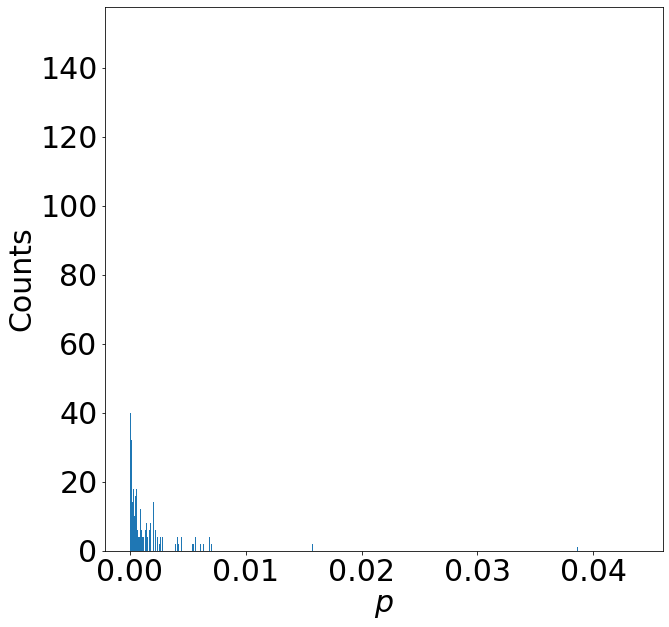

[344  84  42  40  22  14  20   6  10   6   4   4   8   2   4   4   2   2
   2   2   2   2   6   2   2   1   1   1   1]


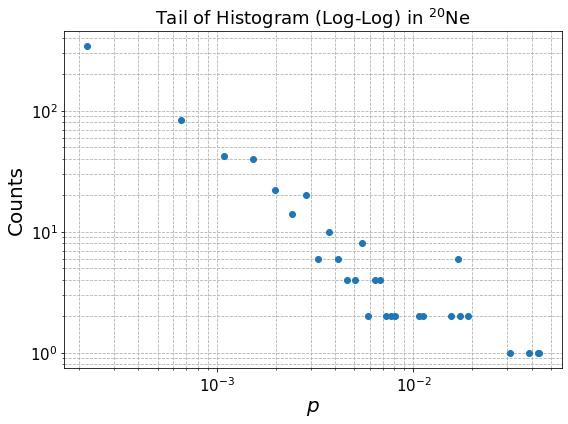

In [17]:
plt.figure(figsize=(10,10))
plt.ylabel('Counts',fontsize=30)
plt.hist(prob,bins=1000)
plt.xlabel(r'$p$',fontsize=30)
plt.tick_params(labelsize=30)
plt.show()



# Compute histogram (don't plot yet)
counts, bin_edges = np.histogram(prob, bins=100,density=False)

# Bin centers (x-axis)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Filter out zero counts to avoid log(0)
nonzero = counts > 0
counts = counts[nonzero]

print(counts)
bin_centers = bin_centers[nonzero]
bin_widths = np.diff(bin_edges)

pdf = counts #/ (np.sum(counts))

# Plot in log-log scale
plt.figure(figsize=(8,6))
plt.loglog(bin_centers, pdf, marker='o', linestyle='none')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.title(r"Tail of Histogram (Log-Log) in "+title, fontsize=18)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

-6.173903974788141
Fitted power law: y ≈ 0.002083 * x^(-1.459)
R² = 0.9416


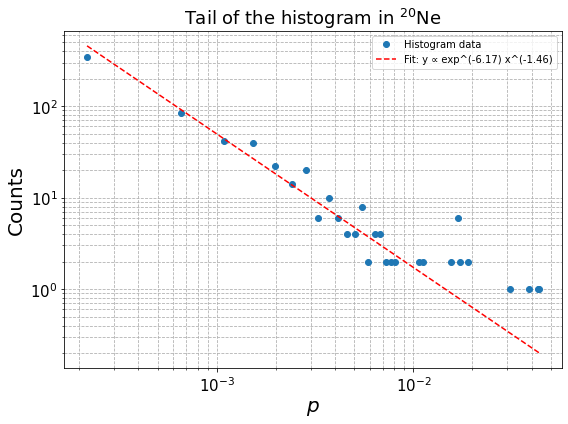

In [16]:
from scipy import stats
mask = counts > 0
x = bin_centers[mask]
y = counts[mask]

# Take logs
logx = np.log(x[x<10**-2])
logy = np.log(y[x<10**-2])

# Fit linear regression in log-log space
slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

# Extract power-law parameters
b = -slope
a = np.exp(intercept)
print(intercept)
print(f"Fitted power law: y ≈ {a:.6f} * x^(-{b:.3f})")
print(f"R² = {r_value**2:.4f}")

# Plot
plt.figure(figsize=(8,6))

plt.title(r"Tail of the histogram in "+title, fontsize=18)
plt.loglog(x, y, 'o', label='Histogram data')
plt.loglog(x, a * x**(-b), 'r--', label=f'Fit: y ∝ exp^({np.log(a):.2f}) x^(-{b:.2f})')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

#### Build-up an algorithm to save the number of instances with a fixed accuracy

Hyperparameters

In [ ]:
nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6),(10,8)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si',r'$^{32}$Ar']

history={}
errors=[]
n_instances_max=[]

for r,title in enumerate(titles):
    print('title=',title)
    nparticles_a=nparts[r][0]
    nparticles_b=nparts[r][1]
    
    history[nparts[r]]=[]
    
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

    print(egs)

    print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
    #print('j_value=',J2Class.j_value(psi0))
    print('dimension=',NSMHamiltonian.hamiltonian.shape[0])
    
    prob=np.conjugate(psi0[:,0])*psi0[:,0]
    
    n_instances=np.arange(2,prob.shape[0])
    
    error=1000
    i=0
    while(error> 10**-3):
        selection=np.random.choice(np.arange(prob.shape[0]),size=n_instances[i],replace=False,p=prob)
        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

        # for a,idx_a in enumerate(selection):
        #     for b,idx_b in enumerate(selection):
        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        
        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        error=np.abs(effective_egs[0]-egs[0])/np.abs(egs[0])
        history[nparts[r]].append(error)
        
        i+=1
    
    n_instances_max.append(i)
    errors.append(error)
    print('\n')
    print(n_instances[i])
    print('error=',np.abs(effective_egs[0]-egs[0])/np.abs(egs[0]),'\n')     
    
    

#### Analysis of the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data=np.load('data/samplebaseddiagonalization_data/run_1%.npz')

errors=data['errors']
titles=data['titles']
history=data['history']
n_instances=data['n_instances']
dimensions=data['dimensions']

print(titles)
# 0 5 9 12
selection=[0,5,9,12]
print(titles[selection])

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell',fontsize=30)
plt.ylabel('n instances',fontsize=30)
plt.bar(np.arange(n_instances.shape[0]),dimensions)
plt.bar(np.arange(n_instances.shape[0]),n_instances)
#plt.semilogy()
plt.xticks(np.arange(n_instances.shape[0]),titles[:n_instances.shape[0]])
#plt.text(x=1,y=80000,s=r'$H=\sum_a e_a c^{+}_a c_a +\frac{1}{4}\sum_{abcd} v_{abdc} c^{+}_a c^{+}_b c_c c_d$',fontsize=30)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title('SBD- Nuclear Shell model Hamiltonian in the sd-shell (1% accuracy energy)',fontsize=30)
plt.ylabel(r'$N_s$',fontsize=30)
plt.xlabel(r'$\dim$',fontsize=30)

plt.scatter(dimensions,dimensions)
plt.plot(dimensions,dimensions)
plt.scatter(dimensions,n_instances)
plt.loglog()

plt.tick_params(labelsize=20)
plt.show()

In [ ]:
plt.scatter(n_instances,dimensions)
plt.loglog()
plt.show()

from scipy import stats

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming these are your data
# dimensions = ...
# n_instances = ...

# Log-transform
x_tilde = np.log(dimensions)
y_tilde = np.log(n_instances)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tilde, y_tilde)
b = slope
a = np.exp(intercept)

print(f"Fitted model: y ≈ {a:.3f} * x^{b:.3f}")
print(f"R² = {r_value**2:.4f}")

# Plot original data and the fitted curve
plt.figure(figsize=(8,6))
plt.scatter(dimensions, n_instances, label='Data', color='blue')

# Create smooth line for fitted curve
x_fit = np.linspace(min(dimensions), max(dimensions), 200)
y_fit = a * x_fit**b
plt.plot(x_fit, y_fit, label=f'Fit: y ≈ {a:.2f} * x^{b:.2f}', color='red', linestyle='--')

# Log scales
plt.xscale('log')
plt.yscale('log')

# Labels
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()
